# MCB final project --- Calcium Imaging Data analysis by PCA/ICA


**Author: Lechen(Selina) Qian**<br>
**Date: 2019.4.23**<br>


In [645]:
import numpy as np
import scipy.stats as stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

from scipy.stats import kurtosis
%matplotlib inline

## Implementation and test of ICA algorithm

### Load mixed images

In [647]:
# read three mixed images
X_1 = pd.read_csv('/Users/lechenqian/OneDrive - Harvard University/Spring 2019/computational neuroscience/HW2/images for ICA (Q.2)/im1.csv',header = None)
X_2 = pd.read_csv('/Users/lechenqian/OneDrive - Harvard University/Spring 2019/computational neuroscience/HW2/images for ICA (Q.2)/im2.csv',header = None)
X_3 = pd.read_csv('/Users/lechenqian/OneDrive - Harvard University/Spring 2019/computational neuroscience/HW2/images for ICA (Q.2)/im3.csv',header = None)

# put them into an empty matrix
X = np.zeros([3,X_1.size])
X[0,:] = np.asarray(X_1).reshape(1,-1) #each row for one image
X[1,:] = np.asarray(X_2).reshape(1,-1)
X[2,:] = np.asarray(X_3).reshape(1,-1)

print('-------------------------------------')
print('The dimesnion of X is ',X.shape[0],' frames and ',X.shape[1],' pixels.')


-------------------------------------
The dimesnion of X is  3  frames and  131072  pixels.


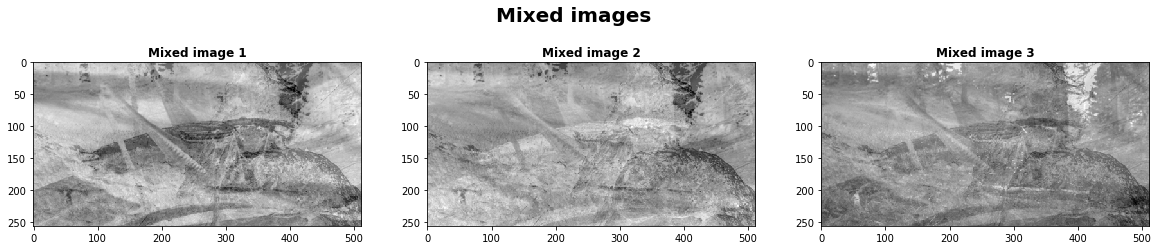

In [111]:
# demonstrate three mixed images
fig, (ax) = plt.subplots(1, 3, figsize=(20, 4))
plt.suptitle("Mixed images", fontsize=20, weight='heavy')
        
for i in range(3):
    ax[i].imshow(X[i,:].reshape(256,512),cmap = 'binary')
    ax[i].set_title("Mixed image {}".format(i+1), weight='bold')

plt.show()

## ICA procedure

### Step1. whiten image##
**Find the covariance matrix of x, C, and an orthogonal matrix U such that the covariance matrix for the whitened input $\hat x^μ = U^T (x_μ − ⟨x⟩)$ is an identity matrix.**

In [132]:
def whiten(X):
    
    # normalization
    X = X - X.mean(axis=1).reshape(X.shape[0],1)
    X = X / np.std(X,axis=1).reshape(X.shape[0],1)
    
    # compute the covariance of the image data
    cov = np.cov(X, rowvar=True)   # cov is (N, N)
    
    # singular value decomposition
    U,S,V = np.linalg.svd(cov)     # U is (N, N), S is (N,)
    
    # build the ZCA matrix
    epsilon = 1e-5
    zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
    
    # transform the image data       
    zca = np.dot(zca_matrix, X) #zca is (N, 3072)
    return zca


In [671]:
# whiten image
zca = whiten(X)

# confirm X is whitened
cov = np.cov(zca, rowvar=True)
cov


array([[ 9.99987977e-01,  3.20310098e-06,  5.07773886e-06],
       [ 3.20310098e-06,  9.99987657e-01, -5.48951971e-06],
       [ 5.07773886e-06, -5.48951971e-06,  9.99986366e-01]])

### Find the un-mixing matrix $W$ ###
**Optimizing kurtosis of the sources with gradient ascent**<br>
**Observe that each row of $W$, $w_k$, can be optimized independently.**<br>
**Initialize it with some small non-zero numbers.**<br>
**Calculate the gradient $\nabla w$ kurtosis $(w_1^T \hat x)$ and in each step**<br>
**update $w$ as $w^t = w^{t−1} + \eta \nabla w kurtosis(w^T \hat x)$**<br>
**with a small $\eta << 1$. After each update, normalize the vector $w$. And make sure each w is orthogonal to eath other. <br> Repeat until $w$ stops changing.** **Find the first source image with the vector you find.** <br>


In [696]:
# mixedimages is the images matrix like X, dimension: Timeframe by Pixels
#ICs is the number of component you want
#lr is learning rate
#epsilon is for convergence

def ICAprocess(mixedimages,ICs,lr, epsilon, printnum = 10):
    length = mixedimages.shape[0]
    
    #initialization and norlization of un-mixing matrix W
    W = abs(np.random.randn(ICs,length))
    W = W/LA.norm(W,1)
    
    # repeat this process for finding basis vector for each independent component
    for i in range(ICs):
        
        # choose one basis vector
        w = W[i,:]

        print('-------------------------')
        print('IC number',str(i))
        
        done = False # for convergence
        kurt = 1000 # inital kurtosis
        ite = 0 # iterations inside the loop
        while not done:
            j = i
            ite += 1
            
            # calculate the kurtosis when projecting data onto each basis vector
            temp_kurt = stats.kurtosis(np.dot(w,mixedimages))
            
            # examine convergence
            if abs(kurt-temp_kurt)< epsilon:
                done = True
            else:
                kurt = temp_kurt
            # for debugging
            if ite%printnum == printnum-1:
                print('Current kurtosis = ', str(temp_kurt))
                
            # optimizing kurtosis by gradient ascent
            grad = np.sign(temp_kurt)*(np.dot(mixedimages,np.power(np.dot(w,mixedimages),3))/mixedimages.size*3)
            w = w + ln*grad
            
            # make sure basis vectors are orthogonal to each other by subtraction
            while j>0:
                j -= 1
                w -= np.dot(w,W[j,:])/np.dot(W[j,:],W[j,:])*W[j,:]
            # normalization for basis vector
            w = (w)/LA.norm(w,1)
        # put one finished basis vector into un-mixing matrix
        W[i,:] = w
    return W

In [698]:
def display(mixedimages,W,index,width, height,cmap = 'Greys',rev = False):
    # Since ICA cannot distinguish the sign of signal, some of images will be reversed in color.
    im = np.dot(W[index,:],mixedimages).reshape(width,height)
    m,M = im.min(),im.max()
    show_im = (im - m)/(M-m)
    if rev:
        plt.imshow(-show_im,cmap = cmap)
    plt.show()
    

-------------------------
IC number 0
Current kurtosis =  2.8761946009749426
Current kurtosis =  3.5772682913580427
Current kurtosis =  3.636220491024985
Current kurtosis =  3.64078382527327
Current kurtosis =  3.641160490320507
Current kurtosis =  3.64119390029923
Current kurtosis =  3.6411970034140966
-------------------------
IC number 1
Current kurtosis =  2.6778394019604734
Current kurtosis =  5.177264388734098
Current kurtosis =  5.665121059649389
Current kurtosis =  5.671475992753278
Current kurtosis =  5.67154767352346
-------------------------
IC number 2
Current kurtosis =  2.5676641504524165
Current kurtosis =  -0.6331719219560545


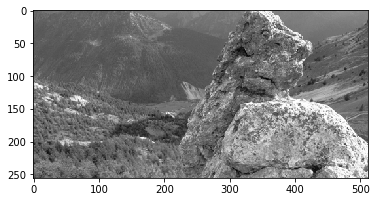

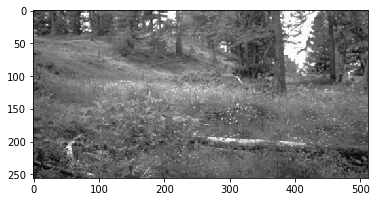

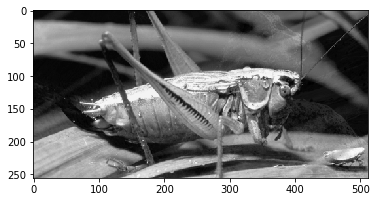

In [699]:
# lr need to be tuned according to dataset
W = ICAprocess(zca,3,lr = 0.1, epsilon = 10e-7,printnum = 2)
display(zca,W,0,256, 512, cmap = 'Greys',rev = True)
display(zca,W,1,256, 512, cmap = 'Greys',rev = True)
display(zca,W,2,256, 512, cmap = 'Greys',rev = True)

In [701]:
# unmixing matrix
W

array([[ 0.12717427,  0.47941358,  0.39341215],
       [ 0.32841729,  0.25485336, -0.41672936],
       [ 0.49408071, -0.30002455,  0.20589474]])

In [356]:
#examine orthogonality
w_1.dot(w_2)

0.0

## Calcium imaging data

### load motion corrected experimental data tiff
**motion corrected is required**

In [702]:
from skimage.external import tifffile as tif
image_path = '/Users/lechenqian/OneDrive - Harvard University/Spring 2019/MCB111/final project/motion_corrected_data.tiff'
image = tif.imread(image_path)
#only use first 1000 frames
image = image[0:1000,:,:]


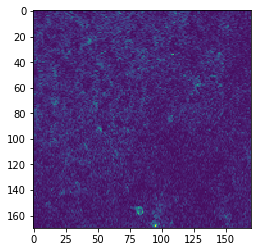

In [85]:
plt.imshow(image[0,:,:])
plt.show()

In [24]:
# save a movie
import imageio
writer = imageio.get_writer('/Users/lechenqian/OneDrive - Harvard University/Spring 2019/MCB111/final project/motion_corrected_movie.avi', fps=30)

for im in image:
    writer.append_data(im)
writer.close()

Lossy conversion from float32 to uint8. Range [-30.20208740234375, 792.5306396484375]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (170, 170) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Lossy conversion from float32 to uint8. Range [-20.734375, 843.0045166015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.040191650390625, 679.29833984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.272064208984375, 800.849853515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.005523681640625, 531.713867187

Lossy conversion from float32 to uint8. Range [-24.3475341796875, 716.789306640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-47.0269775390625, 890.1083374023438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.632720947265625, 1136.116455078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.78143310546875, 1198.013427734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-52.607086181640625, 1235.4122314453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.23248291015625, 1147.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.984130859375, 990.6228637695312]. Convert image 

Lossy conversion from float32 to uint8. Range [-29.76507568359375, 524.5494384765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.380157470703125, 527.5511474609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.6021728515625, 498.0455017089844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-41.930206298828125, 506.09942626953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.13043212890625, 631.10498046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.815582275390625, 563.8027954101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.626983642578125, 505.6611633300781].

Lossy conversion from float32 to uint8. Range [-24.43902587890625, 591.1083984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.472747802734375, 489.0407409667969]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-19.325531005859375, 657.9068603515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.71893310546875, 502.26495361328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.373779296875, 451.0382995605469]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-42.3026123046875, 462.99285888671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.14190673828125, 553.1270751953125]. Con

Lossy conversion from float32 to uint8. Range [-28.891998291015625, 774.9193115234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.025390625, 621.309814453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.4150390625, 944.567138671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.753204345703125, 608.54833984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.5364990234375, 553.0772094726562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.361785888671875, 584.2048950195312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.772796630859375, 473.9708251953125]. Convert ima

Lossy conversion from float32 to uint8. Range [-27.040283203125, 525.9296264648438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.445526123046875, 1000.878173828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.159423828125, 578.031494140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.9219970703125, 551.1241455078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.92901611328125, 772.3900146484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.12359619140625, 909.63134765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.192047119140625, 738.1087036132812]. Convert

Lossy conversion from float32 to uint8. Range [-33.209442138671875, 452.25927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.010284423828125, 499.7107849121094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.872344970703125, 535.5787963867188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.53851318359375, 467.8533935546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.204254150390625, 629.4624633789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.6446533203125, 590.1259765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.05596923828125, 593.1597290039062]. Con

Lossy conversion from float32 to uint8. Range [-28.368927001953125, 466.0924072265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.591796875, 490.1297607421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.558837890625, 517.8023681640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.92364501953125, 540.5789794921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.25042724609375, 754.941650390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.186859130859375, 416.0150146484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.91961669921875, 489.41497802734375]. Conver

Lossy conversion from float32 to uint8. Range [-20.4368896484375, 501.21435546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-42.289337158203125, 437.816650390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.73028564453125, 813.603515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.16693115234375, 467.71875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.2662353515625, 642.4591674804688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.798797607421875, 568.81298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.18218994140625, 490.2055969238281]. Convert image to u

Lossy conversion from float32 to uint8. Range [-40.3502197265625, 434.08001708984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.90863037109375, 536.8724365234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.3350830078125, 400.35302734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.927032470703125, 547.1113891601562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.215911865234375, 445.86370849609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.828765869140625, 759.7587890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.065093994140625, 534.884033203125]. Con

Lossy conversion from float32 to uint8. Range [-38.035003662109375, 529.49072265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.056549072265625, 532.4296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.67041015625, 491.4618835449219]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.618133544921875, 432.2221374511719]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.774810791015625, 551.0072631835938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.916534423828125, 1375.2315673828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.812042236328125, 1851.51904296875]. Conver

Lossy conversion from float32 to uint8. Range [-37.486297607421875, 687.4793701171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.239715576171875, 516.2962036132812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.79254150390625, 489.74810791015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.070037841796875, 689.6044921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-40.450439453125, 462.89154052734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.660125732421875, 493.90625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.85382080078125, 508.873291015625]. Convert i

Lossy conversion from float32 to uint8. Range [-36.388092041015625, 544.277099609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.62109375, 680.2692260742188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.803070068359375, 657.0445556640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.969940185546875, 508.65380859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.22137451171875, 485.60894775390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.094146728515625, 528.031005859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.668182373046875, 468.8259582519531]. Conve

Lossy conversion from float32 to uint8. Range [-27.31829833984375, 621.5015258789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.108551025390625, 609.2256469726562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.59375, 1598.5037841796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.8287353515625, 1449.023681640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.508056640625, 1277.7962646484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.269805908203125, 1029.60888671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.769073486328125, 1185.82177734375]. Convert im

Lossy conversion from float32 to uint8. Range [-29.86962890625, 580.3579711914062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.8157958984375, 697.548828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.468475341796875, 810.9864501953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.506866455078125, 732.58544921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.388397216796875, 654.327392578125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.173553466796875, 912.1578369140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.270416259765625, 848.3825073242188]. Convert

Lossy conversion from float32 to uint8. Range [-23.36065673828125, 638.4851684570312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.223297119140625, 567.934814453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.18310546875, 633.32421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.57470703125, 524.459716796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.13861083984375, 516.373291015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.335174560546875, 458.40069580078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.73834228515625, 445.1170654296875]. Convert imag

Lossy conversion from float32 to uint8. Range [-20.926605224609375, 904.769287109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.70330810546875, 621.0435180664062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.963287353515625, 597.77880859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.005218505859375, 445.6141357421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.06134033203125, 619.730224609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.69512939453125, 444.54656982421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.5140380859375, 467.61279296875]. Conv

Lossy conversion from float32 to uint8. Range [-25.5189208984375, 558.624755859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18.1220703125, 579.6505126953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.89312744140625, 712.1366577148438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.75347900390625, 574.81591796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.9317626953125, 491.0829162597656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.239501953125, 562.7703247070312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.698150634765625, 544.5523681640625]. Convert ima

Lossy conversion from float32 to uint8. Range [-33.369293212890625, 501.79522705078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.7705078125, 640.9019775390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-40.30206298828125, 400.3551940917969]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.797332763671875, 640.1834716796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.463836669921875, 485.01824951171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.315338134765625, 461.7421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.5836181640625, 447.86724853515625]. Conve

Lossy conversion from float32 to uint8. Range [-33.11444091796875, 580.1134033203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.771392822265625, 468.8365783691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.10406494140625, 473.9182434082031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18.39361572265625, 442.47412109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.750946044921875, 454.6558532714844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.263671875, 555.8193359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.82171630859375, 426.83465576171875]. Convert 

Lossy conversion from float32 to uint8. Range [-24.248291015625, 629.833251953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.549560546875, 631.255615234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.34564208984375, 564.8834228515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.300262451171875, 430.91522216796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.739898681640625, 911.5579223632812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.97259521484375, 596.6023559570312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-13.70281982421875, 587.0]. Convert image to

Lossy conversion from float32 to uint8. Range [-29.063018798828125, 552.3318481445312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.709381103515625, 663.3902587890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.218780517578125, 579.157470703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.6146240234375, 424.8260192871094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.0755615234375, 576.59033203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.65216064453125, 734.6414184570312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.914642333984375, 464.71533203125]. Conv

Lossy conversion from float32 to uint8. Range [-24.8001708984375, 493.96685791015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.861541748046875, 467.804931640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.3564453125, 543.298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.103515625, 523.211181640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.57659912109375, 522.5390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.117523193359375, 503.46734619140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.812652587890625, 493.5740966796875]. Convert image to u

Lossy conversion from float32 to uint8. Range [-33.96875, 1120.25]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.4056396484375, 957.07666015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-45.6163330078125, 1066.32666015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-56.111602783203125, 1367.9820556640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.239990234375, 1174.393798828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.9486083984375, 1341.9619140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.588623046875, 1417.2462158203125]. Convert image to uint8 prior 

Lossy conversion from float32 to uint8. Range [-33.891021728515625, 686.8138427734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.0234375, 477.58636474609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.188812255859375, 504.0694885253906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.772125244140625, 471.4456481933594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.867523193359375, 653.890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.707611083984375, 694.6173095703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.60504150390625, 741.510986328125]. Convert im

Lossy conversion from float32 to uint8. Range [-34.5052490234375, 518.532470703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.9127197265625, 503.2648620605469]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.28094482421875, 568.40673828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.907989501953125, 509.5278625488281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.33734130859375, 505.99798583984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.739532470703125, 522.908935546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.701751708984375, 498.91064453125]. Conve

Lossy conversion from float32 to uint8. Range [-20.484039306640625, 766.4396362304688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.36492919921875, 524.9472045898438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.093475341796875, 520.1163940429688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.539520263671875, 722.1590576171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.977996826171875, 526.8126220703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.8497314453125, 737.55859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.407196044921875, 480.8743896484375]. Co

Lossy conversion from float32 to uint8. Range [-36.429962158203125, 426.75823974609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.4190673828125, 485.0353088378906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.916259765625, 623.0402221679688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.1405029296875, 497.15789794921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.1690673828125, 583.9141845703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.24554443359375, 503.4517822265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.59771728515625, 812.1411743164062]. Con

Lossy conversion from float32 to uint8. Range [-55.63897705078125, 571.788818359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.584442138671875, 527.96875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.43896484375, 615.09228515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.599212646484375, 947.8915405273438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.71466064453125, 553.64990234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.51953125, 612.7811279296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.9273681640625, 714.6026611328125]. Convert image to uint8

Lossy conversion from float32 to uint8. Range [-24.2115478515625, 546.5502319335938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.293548583984375, 771.7279052734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.84765625, 685.864501953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.854583740234375, 461.70574951171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.06414794921875, 594.15673828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.632110595703125, 500.84844970703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18.24444580078125, 625.602294921875]. Convert

Lossy conversion from float32 to uint8. Range [-34.314300537109375, 609.0732421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.38189697265625, 529.5821533203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.488800048828125, 721.4632568359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.86700439453125, 572.491943359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.0296630859375, 492.5902099609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.9805908203125, 454.0976257324219]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.3287353515625, 475.5182189941406]. Conver

Lossy conversion from float32 to uint8. Range [-14.9111328125, 812.5515747070312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.2265625, 571.648193359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.190948486328125, 564.5405883789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.235015869140625, 551.0443115234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18.8349609375, 630.3624267578125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.0596923828125, 434.7735595703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.602935791015625, 764.886474609375]. Convert image to

Lossy conversion from float32 to uint8. Range [-33.664093017578125, 680.16259765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.6663818359375, 619.4345703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.218780517578125, 493.83868408203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-44.901519775390625, 483.109130859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.20458984375, 675.32763671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.34857177734375, 501.99395751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.76104736328125, 430.17822265625]. Convert im

Lossy conversion from float32 to uint8. Range [-40.76715087890625, 534.6030883789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.157958984375, 483.17120361328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.976470947265625, 638.2244262695312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.832061767578125, 486.77386474609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.895355224609375, 613.817626953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.591522216796875, 411.5506591796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.577484130859375, 557.6893310546875

Lossy conversion from float32 to uint8. Range [-22.91162109375, 756.4570922851562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.55010986328125, 450.8680419921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.692138671875, 568.69140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.792266845703125, 629.8732299804688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.994140625, 615.1632080078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.42169189453125, 499.1949462890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.29486083984375, 481.9832763671875]. Convert image t

Lossy conversion from float32 to uint8. Range [-31.566986083984375, 713.0634765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.021636962890625, 839.9432373046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.210845947265625, 819.653564453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.78387451171875, 827.1507568359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-42.1197509765625, 688.9105224609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.03961181640625, 641.3768310546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.1412353515625, 673.2129516601562]. Conv

Lossy conversion from float32 to uint8. Range [-34.462249755859375, 562.4364013671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.9898681640625, 618.577880859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.53997802734375, 570.703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.13433837890625, 579.8599853515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.80206298828125, 434.87060546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.99609375, 552.5537109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.233612060546875, 440.929443359375]. Convert image to uin

Lossy conversion from float32 to uint8. Range [-25.2708740234375, 549.0686645507812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.23291015625, 505.35699462890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.199188232421875, 457.0572814941406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.0380859375, 493.559326171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.58648681640625, 533.1724243164062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.592926025390625, 427.77642822265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.429901123046875, 439.0531921386719]. Conve

Lossy conversion from float32 to uint8. Range [-27.10809326171875, 499.34332275390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-46.769439697265625, 521.2269287109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.03179931640625, 484.9841613769531]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.48895263671875, 623.42138671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.817352294921875, 529.6416625976562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.753814697265625, 513.8492431640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.70770263671875, 735.1319580078125].

Lossy conversion from float32 to uint8. Range [-29.012725830078125, 436.35089111328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.82940673828125, 437.4049072265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.5804443359375, 494.6296691894531]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.201629638671875, 630.230712890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.435089111328125, 513.406982421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.59735107421875, 456.8817138671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-16.515869140625, 608.874267578125]. Con

Lossy conversion from float32 to uint8. Range [-26.795074462890625, 690.059814453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.38800048828125, 474.8263854980469]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.519744873046875, 533.9766845703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.822235107421875, 582.58203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-19.2138671875, 741.7626953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.077392578125, 611.1072998046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-19.992401123046875, 731.254150390625]. Convert image

Lossy conversion from float32 to uint8. Range [-59.28582763671875, 706.2698974609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.700714111328125, 843.8349609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.677459716796875, 641.7650146484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.93475341796875, 496.893310546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.807586669921875, 700.9317626953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.95953369140625, 572.6615600585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-40.17724609375, 655.0537109375]. Convert 

Lossy conversion from float32 to uint8. Range [-23.315093994140625, 644.272216796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18.5546875, 636.8046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.204498291015625, 609.4202270507812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.719970703125, 528.7429809570312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.03759765625, 552.3170776367188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.349761962890625, 638.0105590820312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.03192138671875, 700.5811767578125]. Convert image to 

Lossy conversion from float32 to uint8. Range [-43.5048828125, 722.522216796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.23382568359375, 699.8297729492188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.829986572265625, 667.732177734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-49.069610595703125, 719.6599731445312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.15069580078125, 617.6253662109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.398712158203125, 717.7734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.49102783203125, 595.3793334960938]. Convert im

Lossy conversion from float32 to uint8. Range [-30.7158203125, 2159.586669921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.085357666015625, 1783.1419677734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.633270263671875, 1742.2806396484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.4053955078125, 1686.2554931640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.498565673828125, 2011.2596435546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.4847412109375, 1369.837646484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.13189697265625, 1437.400146484375]. 

Lossy conversion from float32 to uint8. Range [-32.597869873046875, 523.0260009765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.044830322265625, 544.4821166992188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.569122314453125, 418.87908935546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.26300048828125, 474.5205078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.80401611328125, 487.6995544433594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.33062744140625, 555.0406494140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.499969482421875, 621.7437744140625].

Lossy conversion from float32 to uint8. Range [-32.79913330078125, 1243.205078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.420928955078125, 1149.2740478515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.507080078125, 927.7306518554688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.238525390625, 1148.5789794921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-60.161224365234375, 1749.4547119140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-59.533172607421875, 1756.2430419921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.469207763671875, 2203.7724609375]. Co

Lossy conversion from float32 to uint8. Range [-37.0015869140625, 532.2421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.11590576171875, 456.4150390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-42.611175537109375, 574.7874755859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.136810302734375, 488.19207763671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.9224853515625, 535.0006103515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.308258056640625, 556.1152954101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-43.288421630859375, 525.5867309570312]. Convert

Lossy conversion from float32 to uint8. Range [-37.620147705078125, 1821.0321044921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.783660888671875, 1666.0640869140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.20037841796875, 1279.167724609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.3861083984375, 1209.134765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.43719482421875, 1385.996826171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-46.76727294921875, 1101.948974609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.602294921875, 1139.653076171875]. Con

Lossy conversion from float32 to uint8. Range [-44.446685791015625, 1179.35107421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.66363525390625, 1081.0374755859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-55.921630859375, 1244.7869873046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-44.906829833984375, 1174.4517822265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.477874755859375, 1105.9814453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-51.0880126953125, 1007.4775390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.592926025390625, 1200.644287109375]. Co

Lossy conversion from float32 to uint8. Range [-26.762969970703125, 602.5699462890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.6103515625, 840.8925170898438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.373046875, 548.0428466796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.664581298828125, 618.5064697265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-46.64276123046875, 469.68701171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.831207275390625, 551.6376953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.676177978515625, 651.072998046875]. Convert imag

Lossy conversion from float32 to uint8. Range [-32.504608154296875, 486.5306396484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.704559326171875, 482.01806640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.773101806640625, 549.7269897460938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.66949462890625, 410.2994384765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.174652099609375, 547.7618408203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.177703857421875, 677.6947021484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-46.76519775390625, 978.1513671875]. C

Lossy conversion from float32 to uint8. Range [-23.227386474609375, 539.4624633789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.86236572265625, 526.27294921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.30926513671875, 587.2678833007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-58.264007568359375, 607.056396484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.126861572265625, 465.57574462890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.790924072265625, 419.4994201660156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.080596923828125, 480.3924255371094]

Lossy conversion from float32 to uint8. Range [-23.312896728515625, 499.8717346191406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-42.283447265625, 609.0123901367188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.882904052734375, 521.3306884765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.705963134765625, 484.38525390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.3094482421875, 510.3513488769531]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.34375, 522.8517456054688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.561614990234375, 816.3793334960938]. Convert ima

Lossy conversion from float32 to uint8. Range [-32.948272705078125, 577.094482421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-38.50604248046875, 510.050048828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-19.212249755859375, 622.9027099609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.101715087890625, 584.6663208007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.627227783203125, 515.0661010742188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.7596435546875, 738.4356689453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.1805419921875, 550.0232543945312]. C

In [703]:
# save a gif
imageio.mimsave('/Users/lechenqian/OneDrive - Harvard University/Spring 2019/MCB111/final project/motion_corrected_movie.gif', image, fps=30)

Lossy conversion from float32 to uint8. Range [-30.20208740234375, 792.5306396484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.734375, 843.0045166015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.040191650390625, 679.29833984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.272064208984375, 800.849853515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.005523681640625, 531.7138671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-46.6171875, 550.5072021484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.8314208984375, 585.6624145507812]. Convert image to uin

Lossy conversion from float32 to uint8. Range [-26.632720947265625, 1136.116455078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.78143310546875, 1198.013427734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-52.607086181640625, 1235.4122314453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.23248291015625, 1147.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.984130859375, 990.6228637695312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.69561767578125, 1020.7296752929688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.95428466796875, 834.26318359375]. Convert imag

Lossy conversion from float32 to uint8. Range [-30.6021728515625, 498.0455017089844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-41.930206298828125, 506.09942626953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.13043212890625, 631.10498046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.815582275390625, 563.8027954101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.626983642578125, 505.6611633300781]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.675933837890625, 616.1840209960938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.392822265625, 503.8968811035156]. C

Lossy conversion from float32 to uint8. Range [-19.325531005859375, 657.9068603515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.71893310546875, 502.26495361328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.373779296875, 451.0382995605469]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-42.3026123046875, 462.99285888671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.14190673828125, 553.1270751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.26446533203125, 528.21728515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.9896240234375, 509.12298583984375]. Con

Lossy conversion from float32 to uint8. Range [-30.4150390625, 944.567138671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.753204345703125, 608.54833984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.5364990234375, 553.0772094726562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-34.361785888671875, 584.2048950195312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.772796630859375, 473.9708251953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.5093994140625, 496.75714111328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.393585205078125, 520.3115234375]. Convert 

Lossy conversion from float32 to uint8. Range [-28.159423828125, 578.031494140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.9219970703125, 551.1241455078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.92901611328125, 772.3900146484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.12359619140625, 909.63134765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.192047119140625, 738.1087036132812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.44140625, 1160.060302734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.4273681640625, 742.7236328125]. Convert image to

Lossy conversion from float32 to uint8. Range [-23.872344970703125, 535.5787963867188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.53851318359375, 467.8533935546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.204254150390625, 629.4624633789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.6446533203125, 590.1259765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-36.05596923828125, 593.1597290039062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.159454345703125, 547.4498291015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.65753173828125, 489.388916015625]. Con

Lossy conversion from float32 to uint8. Range [-23.558837890625, 517.8023681640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.92364501953125, 540.5789794921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.25042724609375, 754.941650390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.186859130859375, 416.0150146484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.91961669921875, 489.41497802734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-55.40521240234375, 541.5250854492188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.0625, 537.7420043945312]. Convert imag

Lossy conversion from float32 to uint8. Range [-25.73028564453125, 813.603515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-32.16693115234375, 467.71875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.2662353515625, 642.4591674804688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.798797607421875, 568.81298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.18218994140625, 490.2055969238281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.045135498046875, 491.2089538574219]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.464202880859375, 409.98907470703125]. Convert imag

Lossy conversion from float32 to uint8. Range [-33.3350830078125, 400.35302734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.927032470703125, 547.1113891601562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.215911865234375, 445.86370849609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.828765869140625, 759.7587890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.065093994140625, 534.884033203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.644195556640625, 470.33453369140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.56756591796875, 606.07958984375]. Con

Lossy conversion from float32 to uint8. Range [-26.618133544921875, 432.2221374511719]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-21.774810791015625, 551.0072631835938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-39.916534423828125, 1375.2315673828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.812042236328125, 1851.51904296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-98.65829467773438, 2215.987060546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.9471435546875, 1947.2156982421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.9390869140625, 1970.875244140625]

Lossy conversion from float32 to uint8. Range [-24.070037841796875, 689.6044921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-40.450439453125, 462.89154052734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.660125732421875, 493.90625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.85382080078125, 508.873291015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.281829833984375, 825.232666015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.446746826171875, 511.9677734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.23828125, 527.4937744140625]. Convert image to uin

Lossy conversion from float32 to uint8. Range [-22.969940185546875, 508.65380859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.22137451171875, 485.60894775390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.094146728515625, 528.031005859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.668182373046875, 468.8259582519531]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.39105224609375, 428.70233154296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.311431884765625, 463.26019287109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-42.2137451171875, 431.6473693847656]

Lossy conversion from float32 to uint8. Range [-28.508056640625, 1277.7962646484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.269805908203125, 1029.60888671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.769073486328125, 1185.82177734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.657501220703125, 926.5353393554688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.390533447265625, 878.947265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.387451171875, 705.5509033203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.602142333984375, 703.2675170898438]. Conve

Lossy conversion from float32 to uint8. Range [-33.388397216796875, 654.327392578125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.173553466796875, 912.1578369140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.270416259765625, 848.3825073242188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.109375, 748.867431640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.4451904296875, 597.3124389648438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-18.75, 713.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.721527099609375, 716.3449096679688]. Convert image to uint8 prior to 

Lossy conversion from float32 to uint8. Range [-24.13861083984375, 516.373291015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-22.335174560546875, 458.40069580078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.73834228515625, 445.1170654296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.97216796875, 501.302490234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-41.7822265625, 453.64837646484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-25.98828125, 408.86517333984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-26.649444580078125, 506.1844177246094]. Convert ima

Lossy conversion from float32 to uint8. Range [-22.06134033203125, 619.730224609375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.69512939453125, 444.54656982421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-31.5140380859375, 467.61279296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-35.239654541015625, 702.131103515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-33.765167236328125, 440.478515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-37.635162353515625, 576.5160522460938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.39080810546875, 407.5658874511719]. Conver

Lossy conversion from float32 to uint8. Range [-28.239501953125, 562.7703247070312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-27.698150634765625, 544.5523681640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-24.6810302734375, 549.0685424804688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.121002197265625, 509.257568359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-23.5631103515625, 571.5296630859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-11.507415771484375, 525.57177734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.39599609375, 764.9359130859375]. Convert 

Lossy conversion from float32 to uint8. Range [-36.315338134765625, 461.7421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-29.5836181640625, 447.86724853515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.82623291015625, 480.6268005371094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-20.07232666015625, 497.5111083984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-46.163421630859375, 975.6708374023438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-30.51092529296875, 491.61993408203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-28.286529541015625, 493.31903076171875]. Co

### PCA: removing artifacts, noise and dimension reduction

In [102]:
pixw = image.shape[1] #width
pixh = image.shape[2] # height
nt = image.shape[0] #total frames
npix = pixw*pixh # total pixels
print(nt,' time frames x',npix,'pixels ')
print('----------------------------------------')
if nt<npix:
    print('using temporal covariance matrix.\n')
else:
    print('using spatial covariance matrix.\n')


1000  time frames x 28900 pixels 
----------------------------------------
using temporal covariance matrix.



In [90]:
# covariance matrix
image_reshape = image.reshape(nt,npix)
image_reshape_cov = np.cov(image_reshape)


In [93]:
# return number of PCs that explaines the percentage you specified
def nPCs(eigenvalues,percentage):
    #for descending order eigenvalues
    sum = 0
    for i,value in enumerate(eigenvalues):
        sum += value
        if sum >= percentage*np.sum(eigenvalues):
            break
    return i
        


In [ ]:
# SVD: eigenvalues and eigenvectors(mixsig)
eigenvalue,eigenvec = np.linalg.eigh(image_reshape_cov)

# arrange in descending manner
sort_index = np.argsort(-eigenvalue)
eigenvec = eigenvec[:,sort_index]
eigenvalue = eigenvalue[sort_index]

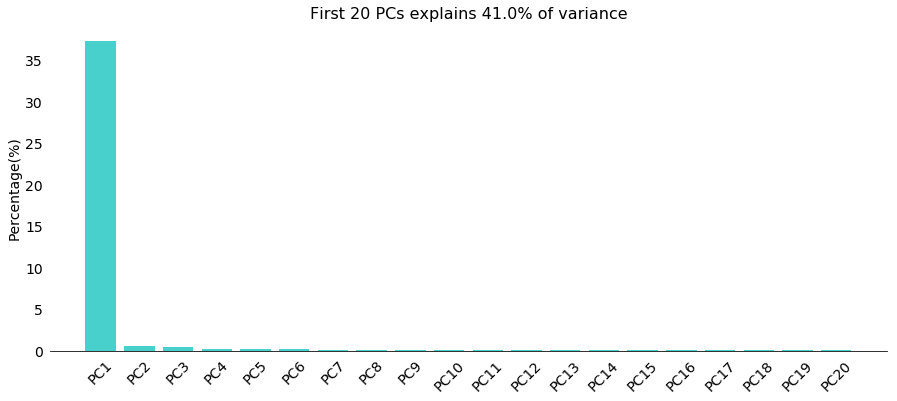

In [565]:
fig,ax2 = plt.subplots(1,1,figsize=(15,6))

# number of PCs you choose to demonstrate

x = np.linspace(1,30,20)
ax2.bar(x,eigenvalue[0:20]/np.sum(eigenvalue)*100,width = 1.2,color = 'mediumTURQUOISE') #color code TURQUOISE, 
ax2.set_xlim([-1,32])
anno = []
for i in range(20):
    anno.append('PC'+str(i+1))
ax2.set_xticks(x)
ax2.set_xticklabels( anno, rotation=45 ) ;
ax2.set_ylabel('Percentage(%)',fontsize = 14)
ax2.set_title('First 20 PCs explains '+str(np.round(np.sum(eigenvalue[0:20]/np.sum(eigenvalue)*100)))+'% of variance',fontsize = 16)
   
ax2.spines["top"].set_visible(False)    
ax2.spines["left"].set_visible(False)    
   
ax2.spines["right"].set_visible(False)    

#plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
 
ax2.get_xaxis().tick_bottom()    
ax2.get_yaxis().tick_left()
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")   

plt.show()

### artifacts removal

In [109]:
# keep PCs that can explain 80% of the variation

PCs = nPCs(eigenvalue,0.8)


In [111]:
# get spatial filter: mixedfilters are PCs.

Sinv = np.linalg.inv(np.diag(eigenvalue[0:PCs]**(1/2)))
image_tm = np.mean(image_reshape,axis = 1) # Average over space
image_use = (image_reshape.T - image_tm.T).T # center
mixedfilters = image_use.T.dot(eigenvec[:,0:PCs].dot( Sinv)).T
mixedfilters = mixedfilters.reshape(PCs,pixw,pixh)

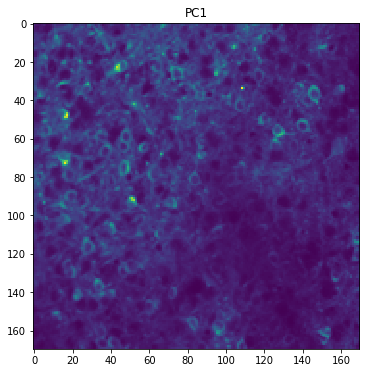

In [709]:
# demonstrate PC1
# im: index of PC you want to see
im = 0
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(mixedfilters[im,:,:])
ori_mixedfilters[im,:,:] = (mixedfilters[im,:,:]-minVal)/(maxVal-minVal)
fig, ax1 = plt.subplots(1,1,figsize=(15,6))

ax1.imshow(mixedfilters[im,:,:])
ax1.set_title('PC{}'.format(im+1))
plt.show()

### ICA after PCA

In [534]:
### using mixedfilter to ICA
ICs = 30
ln = 5 #learning rate
# here F is un-mixing matrix
F= abs(np.random.randn(ICs,PCs))
mixedfilters = mixedfilters.reshape(PCs,npix)
F = F/LA.norm(F,2)
for i in range(ICs):
    w = F[i,:]
    
    print('-------------------------')
    print('IC number',str(i))
    done = False
    kurt = 1000
    ite = 0
    while not done:
        j = i
        ite += 1
        temp_kurt = stats.kurtosis(np.dot(w,mixedfilters))
        if abs(kurt-temp_kurt)<0.0000001:
            done = True
        else:
            kurt = temp_kurt
        if ite%100 == 99:
            print('Current kurtosis = ', str(temp_kurt))
        grad = np.sign(temp_kurt)*(np.dot(mixedfilters,np.power(np.dot(w,mixedfilters),3))/mixedfilters.size*3)
        w = w + ln*grad
        
        while j>-1:
            j -= 1
            w -= np.dot(w,F[j,:])/np.dot(F[j,:],F[j,:])*F[j,:]

        w = (w)/LA.norm(w,1)
    F[i,:] = w

-------------------------
IC number 0
Current kurtosis =  1.5681083741269255
Current kurtosis =  1.739813103148835
Current kurtosis =  2.0227991322250123
Current kurtosis =  2.5863200458199618
Current kurtosis =  4.149237876994267
Current kurtosis =  13.343551596431553
Current kurtosis =  459.9290351301772
Current kurtosis =  644.1028803811145
-------------------------
IC number 1
Current kurtosis =  1.4699871975251062
Current kurtosis =  1.6158057389056903
Current kurtosis =  1.8391280072477887
Current kurtosis =  2.2477401507309507
Current kurtosis =  3.3066493719702725
Current kurtosis =  10.06923079846125
Current kurtosis =  1000.3455177078499
Current kurtosis =  1009.7717042266287
Current kurtosis =  1014.0287328027698
Current kurtosis =  1033.8563959094809
Current kurtosis =  1039.1910414893553
Current kurtosis =  1039.2065269022346
-------------------------
IC number 2
Current kurtosis =  1.230576216683521
Current kurtosis =  1.2898570810996333
Current kurtosis =  1.364401269079

Current kurtosis =  363.72485892164457
Current kurtosis =  363.7260289477533
-------------------------
IC number 17
Current kurtosis =  1.2134482074859285
Current kurtosis =  1.2923929684205433
Current kurtosis =  1.3931933326793153
Current kurtosis =  1.530033376678313
Current kurtosis =  1.7336052396308697
Current kurtosis =  2.084077039514261
Current kurtosis =  2.8629966093045143
Current kurtosis =  5.795102073509042
Current kurtosis =  75.04139397725388
-------------------------
IC number 18
Current kurtosis =  1.1219454182307258
Current kurtosis =  1.1535879147229329
Current kurtosis =  1.1877434858221392
Current kurtosis =  1.2250183801036032
Current kurtosis =  1.2663376778519302
Current kurtosis =  1.3131961227938351
Current kurtosis =  1.3682410901866753
Current kurtosis =  1.4367112040841974
Current kurtosis =  1.5305376798549064
Current kurtosis =  1.6828703690789002
Current kurtosis =  2.0193438247546034
Current kurtosis =  3.4067592867990433
Current kurtosis =  62.8190493

Current kurtosis =  1.5556510402830739
Current kurtosis =  1.7542208831274326
Current kurtosis =  2.1043419788070032
Current kurtosis =  2.874613107655592
Current kurtosis =  5.377498173396143
Current kurtosis =  25.302365906966756
Current kurtosis =  423.54202033069737
Current kurtosis =  467.3668170583436
Current kurtosis =  467.3853863801571
-------------------------
IC number 27
Current kurtosis =  1.174571931743242
Current kurtosis =  1.2189052624560324
Current kurtosis =  1.2706252668162934
Current kurtosis =  1.3328641699945116
Current kurtosis =  1.410887736245214
Current kurtosis =  1.514220231164085
Current kurtosis =  1.6616152019670043
Current kurtosis =  1.894968610764793
Current kurtosis =  2.3255397393571062
Current kurtosis =  3.336817711765116
Current kurtosis =  7.030085279494925
Current kurtosis =  46.33951746433602
Current kurtosis =  482.27929131133817
Current kurtosis =  494.9606122818702
Current kurtosis =  494.9674063831633
-------------------------
IC number 28

In [615]:
#
ica_W = F
mixedfilters = mixedfilters.reshape(PCs,npix)
ica_filters = ica_W.dot(mixedfilters);

icskew = stats.kurtosis(ica_filters,axis = 1)

sort_index = np.argsort(-icskew)
#eigenvec = eigenvec[:,sort_index]
#eigenvalue = eigenvalue[sort_index]


ica_W = ica_W[sort_index,:]

ica_filters = ica_filters[sort_index,:]
ica_sig = eigenvec[:,0:PCs].dot(ica_W.T)
recon_image = ica_sig.dot(ica_filters)
ica_filters = ica_filters.reshape(ICs, pixw, pixh)

In [571]:
# arrange kurtosis from large to small
icskew[sort_index]

array([2035.36798256, 1850.296488  , 1706.34311999, 1375.05452605,
       1326.96477656, 1121.14840666, 1016.33492003,  753.94804788,
        730.98443849,  724.54396923,  628.08153305,  573.86991543,
        534.30817324,  461.99902166,  459.57160769,  440.90619559,
        440.49712028,  434.11885081,  426.68265247,  418.25275933,
        354.89002688,  347.00372541,  342.59783924,  335.54133592,
        298.36936532,  229.63149754,  221.27523298,  163.91845903,
        123.65820924,   66.53493902])

In [616]:
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(ica_filters[2,:,:])

In [618]:
import cv2
import time
neuro_loc = np.zeros([ICs,2])
for i in range(ICs):
    print('--------------------')
    print('IC', i)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(ica_filters[i,:,:])
    ica_filters[i,:,:] = (ica_filters[i,:,:]-minVal)/(maxVal-minVal)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(ica_filters[i,:,:])
    
    print(np.sum(ica_filters[i,:,:]>maxVal-0.1))
    print(np.sum(ica_filters[i,:,:] < minVal+0.1))
    if np.sum(ica_filters[i,:,:]>maxVal-0.11) < np.sum(ica_filters[i,:,:] < minVal+0.11):
        neuro_loc[i,:] = maxLoc
    else:
        neuro_loc[i,:] = minLoc
        ica_filters[i,:,:] = -ica_filters[i,:,:]
        ica_sig[:,i] = -ica_sig[:,i]
        print('reverse')
        
     
        



--------------------
IC 0
1
28885
--------------------
IC 1
1
28305
--------------------
IC 2
1
28195
--------------------
IC 3
1
26848
--------------------
IC 4
1
9354
--------------------
IC 5
1
27869
--------------------
IC 6
1
28589
--------------------
IC 7
1
28510
--------------------
IC 8
1
1148
--------------------
IC 9
1
26387
--------------------
IC 10
1
28617
--------------------
IC 11
2
23522
--------------------
IC 12
1
27219
--------------------
IC 13
1
21914
--------------------
IC 14
1
27374
--------------------
IC 15
1
25048
--------------------
IC 16
1
27214
--------------------
IC 17
1
25461
--------------------
IC 18
1
26948
--------------------
IC 19
1
12425
--------------------
IC 20
1
26989
--------------------
IC 21
1
7463
--------------------
IC 22
1
26004
--------------------
IC 23
1
25914
--------------------
IC 24
1
23024
--------------------
IC 25
1
14975
--------------------
IC 26
1
1
reverse
--------------------
IC 27
1
683
--------------------
IC 28
1
15

In [574]:
neuro_loc

array([[115.,  14.],
       [ 94.,  26.],
       [ 84.,  46.],
       [108.,  34.],
       [ 38.,  19.],
       [ 28.,  32.],
       [104.,  13.],
       [ 17.,  48.],
       [147.,  41.],
       [ 33., 134.],
       [ 52.,  42.],
       [ 12., 151.],
       [ 43.,  24.],
       [ 43.,  23.],
       [ 66.,  68.],
       [ 17.,  49.],
       [ 51.,  92.],
       [143.,  22.],
       [ 95., 168.],
       [ 44.,  23.],
       [ 14.,  71.],
       [ 50.,  91.],
       [ 67.,  16.],
       [ 30.,   5.],
       [ 17.,  72.],
       [  5.,  93.],
       [115.,  14.],
       [ 45.,  23.],
       [ 17.,  50.],
       [160.,  34.]])

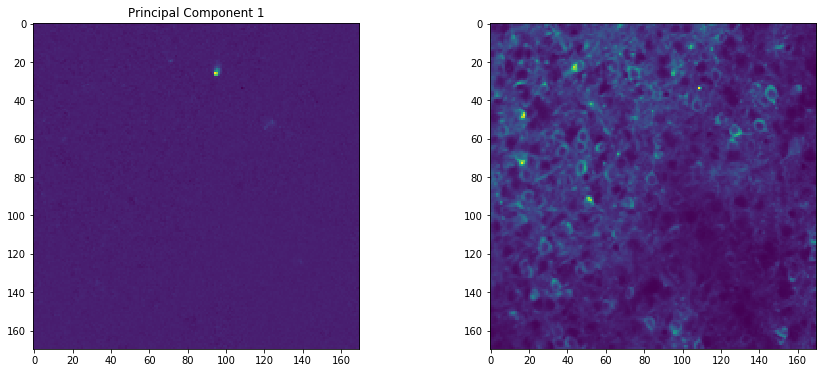

In [712]:
# demonstrate ICs
mixedfilters = mixedfilters.reshape(PCs,pixw,pixh)
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,6))

id_ic = 1
ax1.imshow(ica_filters[id_ic,:,:])
ax1.set_title('Independent Component {}'.format(id_ic))
ax2.imshow(mixedfilters[0,:,:])
ax1.set_title('Principal Component 1')
plt.show()

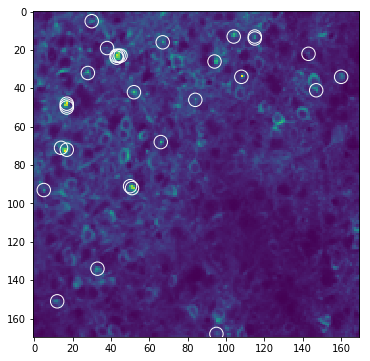

In [716]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(mixedfilters[0,:,:])
for i in range(len(neuro_loc)):
    circle = plt.Circle(neuro_loc[i,:], 3.5, color='w',fill=False)
    ax.add_artist(circle)
plt.show()

In [710]:
def runningmean(x,N):
    cumsum =np.cumsum(np.insert(x,0,0))
    return (cumsum[N:] -cumsum[:-N])/N


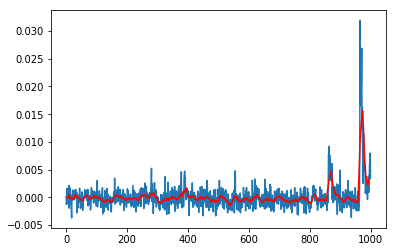

In [714]:
photosignal = ica_sig[:,0]
plt.plot(photosignal)
photosignalaverage = runningmean(photosignal, 15) 
holder = np.zeros(9)
photosignalaverage = np.append(holder,photosignalaverage)
plt.plot(photosignalaverage,'r')
plt.show()

In [643]:
#output GIF file for visualization

import imageio
images_list = [0,1,5,7,9,11,16,18,23]

images = []



for n in images_list:


    
    
    img, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]},figsize=(18, 6))
    a0.imshow(ica_filters[n,:,:])
    
    a0.set_title('Neurons Location:'+str(neuro_loc[n,:]),fontsize = 15)
    #circle = plt.Circle(neuro_loc[n,:], 3.5, color='w',fill=False)
    #a0.add_artist(circle)
    
    
    #a1.plot(ica_sig[:,n])
    photosignalaverage = runningmean(ica_sig[:,n], 15) 
    holder = np.zeros(9)
    photosignalaverage = np.append(holder,photosignalaverage)
    #a1.plot(photosignalaverage,'r')
    
    
    a1.spines["top"].set_visible(False)    
    a1.spines["left"].set_visible(False)    
   
    a1.spines["right"].set_visible(False)    
    a1.spines["bottom"].set_visible(False)
    
    

    #plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
 
    
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="off", left="off", right="off", labelleft="off")   
    plt.savefig('selina.jpg') #Saves each figure as an image
    images.append(imageio.imread('selina.jpg')) #Adds images to list
    

    plt.clf()
    ########################
    
    img, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]},figsize=(18, 6))
    a0.imshow(ica_filters[n,:,:])
    
    a0.set_title('Neurons Location:'+str(neuro_loc[n,:]),fontsize = 15)
    circle = plt.Circle(neuro_loc[n,:], 3.5, color='w',fill=False)
    a0.add_artist(circle)
    
    
    #a1.plot(ica_sig[:,n])
    photosignalaverage = runningmean(ica_sig[:,n], 15) 
    holder = np.zeros(9)
    photosignalaverage = np.append(holder,photosignalaverage)
    #a1.plot(photosignalaverage,'r')
    
    
    a1.spines["top"].set_visible(False)    
    a1.spines["left"].set_visible(False)    
   
    a1.spines["right"].set_visible(False)
    a1.spines["bottom"].set_visible(False)
    
    

    #plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
 
    
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="off", left="off", right="off", labelleft="off")   

    plt.savefig('selina.jpg') #Saves each figure as an image
    images.append(imageio.imread('selina.jpg')) #Adds images to list
    
    plt.clf()
    ########################
    img, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]},figsize=(18, 6))
    a0.imshow(ica_filters[n,:,:])
    
    a0.set_title('Neurons Location:'+str(neuro_loc[n,:]),fontsize = 15)
    circle = plt.Circle(neuro_loc[n,:], 3.5, color='w',fill=False)
    a0.add_artist(circle)
    
    
    a1.plot(ica_sig[:,n],color = 'mediumTURQUOISE')
    photosignalaverage = runningmean(ica_sig[:,n], 15) 
    holder = np.zeros(9)
    photosignalaverage = np.append(holder,photosignalaverage)
    #a1.plot(photosignalaverage,'r')
    a1.set_xlabel('Frames',fontsize = 14)
    a1.set_ylabel('Activities',fontsize = 14)
    a1.spines["top"].set_visible(False)    
    a1.spines["left"].set_visible(False)    
   
    a1.spines["right"].set_visible(False)    

    #plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
 
    a1.get_xaxis().tick_bottom()    
    a1.get_yaxis().tick_left()
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")   

    plt.savefig('selina.jpg') #Saves each figure as an image
    images.append(imageio.imread('selina.jpg')) #Adds images to list
    
  
    plt.clf()
    ########################
    img, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]},figsize=(18, 6))
    a0.imshow(ica_filters[n,:,:])
    
    a0.set_title('Neurons Location:'+str(neuro_loc[n,:]),fontsize = 15)
    circle = plt.Circle(neuro_loc[n,:], 3.5, color='w',fill=False)
    a0.add_artist(circle)
    
    
    a1.plot(ica_sig[:,n],color = 'mediumTURQUOISE',label = 'original intensity')
    photosignalaverage = runningmean(ica_sig[:,n], 15) 
    holder = np.zeros(9)
    photosignalaverage = np.append(holder,photosignalaverage)
    a1.plot(photosignalaverage,color = 'royalblue',label = 'running mean intensity')
    
    a1.set_xlabel('Frames',fontsize = 14)
    a1.set_ylabel('Activities',fontsize = 14)
    a1.spines["top"].set_visible(False)    
    a1.spines["left"].set_visible(False)    
   
    a1.spines["right"].set_visible(False)    

    #plt.yticks(range(0, 91, 10), [str(x) + "%" for x in range(0, 91, 10)], fontsize=14)    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right',frameon=False,prop={'size': 14})
    a1.get_xaxis().tick_bottom()    
    a1.get_yaxis().tick_left()
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")   

    plt.savefig('selina.jpg') #Saves each figure as an image
    images.append(imageio.imread('selina.jpg')) #Adds images to list
    images.append(imageio.imread('selina.jpg'))
    images.append(imageio.imread('selina.jpg'))
    images.append(imageio.imread('selina.jpg'))

    plt.clf()




plt.close()
imageio.mimsave('selina.gif', images, fps=1)

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>